In [1]:
# nth attempt to generate ODE eqs (Von Neumann RHS) 
# given a hamiltonian. and eventually be able to make the RWA

In [1]:
#### modules
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
from sympy import MatrixSymbol,MatMul,Identity,I,Matrix,symbols,Function
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import sympy as sp
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import time

#### local classes
from physconsts import hbar

In [2]:
#### functions

def comm(A,B):
    """
    return commutator(A, B)[A,B]=A.B-B.A. Assumes symbolic matrix.
    """
    assert A.shape == B.shape, (f"A,B must have the same shape, but"+
                                f"A.shape={A.shape} != B.shape={B.shape}")
    return (MatMul(A,B)-MatMul(B,A)) #.as_mutable

In [3]:
def build_derivs(ham, showeqs=False, lambdifyhelp=False):
    """
    return derivatives function with call signature:
    derivs(y0, t) where y0 = [r11, r12, ...] 
    is the unraveled non-redundant density matrix
    
    'ham': a square sympy Matrix representing the full
        system Hamiltonian
    """
    assert ham.shape[0] == ham.shape[1], ("Hamiltonian"+
                                             " must be square, "+
                                             f"not of shape "+
                                              str(ham.shape))
    dims = ham.shape[0]
    # build a symbolic density matrix
    r = MatrixSymbol('r', dims, dims).as_mutable()
    for i in range(dims):
        for j in range(dims):
            r[i,j] = symbols(f'r{i}{j}')
            if i > j:
                r[i,j] = np.conj(r[j,i])
#     print(r) 

    # calculate [r, H]:
    rhs = -1j*comm(r, ham)/hbar

    # prune off non-redundant elements
    pruned_rhs = []
    for i in range(dims):
        for j in range(dims): 
            if i <= j:
                pruned_rhs.append(rhs[i,j])

    # sort arguments in the order of pruned_rhs
    args = list(rhs.free_symbols)
    args.sort(key=lambda x: x.__repr__())
#     args.append(symbols('t'))

    rhs = pruned_rhs

    if showeqs is True:
        print("Equations: \n")
        for var,eq in zip(args,rhs):
            print('D[' + str(var) + '] = ' + str(eq) + '\n')

    f = lambdify(args, rhs) # TODO: include t as argument
    
    if lambdifyhelp:
        print(help(f))

    # okay for time independent Hamiltonian, but need to work 
    # out for when H has explicit t dependence
    def derivs(t, y):  
        """A wrapper for the lambdagenerated function f"""
#         y.append(t)
        return f(*y)
    
    return derivs

In [4]:
#### here's how I want to call my RHS function

# define symbolic matrices which can be made numeric later
E1,E2,d,O = symbols('E1 E2 d O') # symbolic variables

O1 = O2 = 1
D = 10 # detuning much greater than Rabi freq

H = hbar*Matrix([[0,O1/2,0],[O1/2,-D,O2/2],[0,O2/2,0]])
r0 = np.zeros(6, dtype=complex)
r0[0] = 1+0j # start in groundstate

# this is much slower than the equivalent function 
# in symbolic stirap
derivs = build_derivs(H, showeqs=True)

Equations: 

D[r00] = -9.48252172113838e+33*I*(5.272859e-35*r01 - 5.272859e-35*conjugate(r01))

D[r01] = -9.48252172113838e+33*I*(5.272859e-35*r00 - 1.0545718e-33*r01 + 5.272859e-35*r02 - 5.272859e-35*r11)

D[r02] = -9.48252172113838e+33*I*(5.272859e-35*r01 - 5.272859e-35*r12)

D[r11] = -9.48252172113838e+33*I*(-5.272859e-35*r01 + 5.272859e-35*r12 + 5.272859e-35*conjugate(r01) - 5.272859e-35*conjugate(r12))

D[r12] = -9.48252172113838e+33*I*(-5.272859e-35*r02 + 5.272859e-35*r11 + 1.0545718e-33*r12 - 5.272859e-35*r22)

D[r22] = -9.48252172113838e+33*I*(-5.272859e-35*r12 + 5.272859e-35*conjugate(r12))



In [5]:
derivs(0, r0)

[-0j, -0.5j, -0j, -0j, -0j, -0j]

In [18]:
# try to plot the solution in time
t_exp = 35 # units lifetime maybe
tpts = 10000

t0 = time.time()
soln = solve_ivp(derivs,[0,t_exp],r0)
print(f"completed in {(time.time()-t0)*1000} ms")

completed in 209.81526374816895 ms


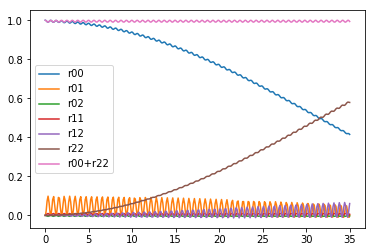

In [20]:
for i,var in zip(range(len(r0)), ['r00','r01','r02','r11','r12','r22']):
    plt.plot(soln.t,np.real(soln.y[i]), label=var)
plt.plot(soln.t, np.real(soln.y[0]+soln.y[-1]),label="r00+r22")
plt.legend(loc='best')